In [144]:
import datetime
import sys
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import itertools
from workalendar.usa import Texas
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from cond_rnn import ConditionalRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import src.preprocessing
from src.functions import load_data, mape, TimeSeriesTensor, create_evaluation_df, series_to_supervised, plot_train_history, validation

np.set_printoptions(threshold=sys.maxsize)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
DAYS_IN_YEAR = 365
HOURS_IN_DAY = 24
DAYS_OF_WEEK = ['week_1','week_2','week_3','week_4','week_5','week_6','week_7']
MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
MINUTES_IN_DAY = MINUTES_IN_HOUR * HOURS_IN_DAY

In [90]:
csv_path = '../data/GEFCom2014/gefcom2014.csv'
df = pd.read_csv(csv_path, index_col=0)

In [91]:
df = src.preprocessing.preprocess(df, 'usa')

In [92]:
df

,value,working day,week_1,week_2,week_3,week_4,week_5,week_6,week_7,fractional hour_sin,fractional hour_cos,day of year_sin,day of year_cos
datetime,,,,,,,,,,,,,
2005-01-01 01:00:00,125.8,0.0,0,0,0,0,0,1,0,0.010908,0.999941,0.000000,1.000000
2005-01-01 02:00:00,121.8,0.0,0,0,0,0,0,1,0,0.021815,0.999762,0.000000,1.000000
2005-01-01 03:00:00,117.0,0.0,0,0,0,0,0,1,0,0.032719,0.999465,0.000000,1.000000
2005-01-01 04:00:00,114.4,0.0,0,0,0,0,0,1,0,0.043619,0.999048,0.000000,1.000000
2005-01-01 05:00:00,113.6,0.0,0,0,0,0,0,1,0,0.054515,0.998513,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-30 20:00:00,183.3,1.0,0,0,1,0,0,0,0,0.216440,0.976296,0.015704,0.999877
2011-11-30 21:00:00,183.3,1.0,0,0,1,0,0,0,0,0.227076,0.973877,0.015704,0.999877
2011-11-30 22:00:00,178.3,1.0,0,0,1,0,0,0,0,0.237686,0.971342,0.015704,0.999877


In [93]:
c1 = df.iloc[:,1:9]
c2 = series_to_supervised(df)
short_df = df.iloc[:,[0,1,-4,-3,-2,-1]].copy()
c1 = c1.loc[c2.index]
short_df = short_df['2005-01-07 02:00:00':]

In [94]:
test_df = short_df.copy()[-8928:]
test_c1 = c1.copy()[-8928:]
test_c2 = c2.copy()[-8928:]

n_test = len(test_df)
index = len(short_df) - n_test
train_val_split = 0

train_df = short_df.copy()[:int(index * (1-train_val_split))]
train_c1 = c1.copy()[:int(index * (1-train_val_split))]
train_c2 = c2.copy()[:int(index * (1-train_val_split))]

val_df = short_df.copy()[int(index * (1-train_val_split)):index]
val_c1 = c1.copy()[:int(index * (1-train_val_split))]
val_c2 = c2.copy()[:int(index * (1-train_val_split))]

In [95]:
train_df

,value,working day,fractional hour_sin,fractional hour_cos,day of year_sin,day of year_cos
datetime,,,,,,
2005-01-07 02:00:00,68.8,1.0,0.021815,0.999762,0.000283,1.000000
2005-01-07 03:00:00,67.1,1.0,0.032719,0.999465,0.000283,1.000000
2005-01-07 04:00:00,67.4,1.0,0.043619,0.999048,0.000283,1.000000
2005-01-07 05:00:00,70.7,1.0,0.054515,0.998513,0.000283,1.000000
2005-01-07 06:00:00,81.4,1.0,0.065403,0.997859,0.000283,1.000000
...,...,...,...,...,...,...
2010-11-23 20:00:00,135.1,1.0,0.216440,0.976296,0.015374,0.999882
2010-11-23 21:00:00,130.0,1.0,0.227076,0.973877,0.015374,0.999882
2010-11-23 22:00:00,120.7,1.0,0.237686,0.971342,0.015374,0.999882


In [96]:
test_df

,value,working day,fractional hour_sin,fractional hour_cos,day of year_sin,day of year_cos
datetime,,,,,,
2010-11-24 01:00:00,89.5,1.0,0.010908,0.999941,0.015421,0.999881
2010-11-24 02:00:00,83.9,1.0,0.021815,0.999762,0.015421,0.999881
2010-11-24 03:00:00,83.5,1.0,0.032719,0.999465,0.015421,0.999881
2010-11-24 04:00:00,85.2,1.0,0.043619,0.999048,0.015421,0.999881
2010-11-24 05:00:00,91.1,1.0,0.054515,0.998513,0.015421,0.999881
...,...,...,...,...,...,...
2011-11-30 20:00:00,183.3,1.0,0.216440,0.976296,0.015704,0.999877
2011-11-30 21:00:00,183.3,1.0,0.227076,0.973877,0.015704,0.999877
2011-11-30 22:00:00,178.3,1.0,0.237686,0.971342,0.015704,0.999877


In [97]:
y_scaler = MinMaxScaler()
y_scaler.fit(train_df[['value']])

MinMaxScaler()

In [98]:
train_c2[['value(t-24)']] = y_scaler.fit_transform(train_c2[['value(t-24)']])

In [99]:
train_c2[['value(t-168)']] = y_scaler.fit_transform(train_c2[['value(t-168)']])

In [100]:
X_scaler = MinMaxScaler()
train_df[train_df.columns] = X_scaler.fit_transform(train_df)
test_df[train_df.columns] = X_scaler.fit_transform(test_df)

In [101]:
T = 24
HORIZON = 24
tensor_structure = {'X':(range(-T+1, 1), ['value','fractional hour_sin','fractional hour_cos','day of year_sin','day of year_cos'])}
train_inputs = TimeSeriesTensor(train_df, 'value', HORIZON, tensor_structure)

In [102]:
test_inputs = TimeSeriesTensor(test_df, 'value', HORIZON, tensor_structure)

In [103]:
print(train_inputs.dataframe.shape)
print(c1.shape)
print(c2.shape)

(51480, 144)
(60432, 8)
(60432, 2)


In [104]:
train_c1 = c1.reindex(train_inputs.dataframe.index)
train_c2 = c2.reindex(train_inputs.dataframe.index)

In [105]:
test_c1 = c1.reindex(test_inputs.dataframe.index)
test_c2 = c2.reindex(test_inputs.dataframe.index)

In [106]:
print(train_inputs.dataframe.shape)
print(train_c1.shape)
print(train_c2.shape)

(51480, 144)
(51480, 8)
(51480, 2)


In [107]:
# FULL DATA
longer_df = df.copy()
#longer_df = longer_df['2012-01-07 02:00:00':]
longer_df = longer_df.merge(series_to_supervised(longer_df), how='right', left_index=True, right_index=True)

In [108]:
# FULL DATA
test_longer_df = longer_df[-8928:].copy()
train_longer_df = longer_df[:-len(test_longer_df)].copy()

In [109]:
# FULL DATA
long_scaler = MinMaxScaler()
test_longer_df[test_longer_df.columns] = X_scaler.fit_transform(test_longer_df)
train_longer_df[train_longer_df.columns] = X_scaler.fit_transform(train_longer_df)

In [110]:
# FULL DATA
T = 24
HORIZON = 24
tensor_structure = {'X':(range(-T+1, 1), train_longer_df.columns)}
train_longer_inputs = TimeSeriesTensor(train_longer_df, 'value', HORIZON, tensor_structure)
test_longer_inputs = TimeSeriesTensor(test_longer_df, 'value', HORIZON, tensor_structure)

In [111]:
df_lags = short_df.merge(series_to_supervised(df), how='right', left_index=True, right_index=True)

In [112]:
test_df_lags = df_lags[-8928:].copy()
train_df_lags = df_lags[:-len(test_df_lags)].copy()

In [113]:
train_Y_df_lags = train_df_lags.iloc[:,0]
test_Y_df_lags = test_df_lags.iloc[:,0]

In [114]:
X_lags_scaler = MinMaxScaler()
train_df_lags[train_df_lags.columns] = X_lags_scaler.fit_transform(train_df_lags)
test_df_lags[test_df_lags.columns] = X_lags_scaler.fit_transform(test_df_lags)

In [115]:
train_X_df_lags = train_df_lags.iloc[:,1:]
test_X_df_lags = test_df_lags.iloc[:,1:]

In [116]:
train_Y1_df_lags = train_df_lags.iloc[:,0]
test_Y1_df_lags = test_df_lags.iloc[:,0]

In [117]:
train_X_df_lags = np.asarray(train_X_df_lags).reshape((train_X_df_lags.shape[0], 1, train_X_df_lags.shape[1]))
test_X_df_lags = np.asarray(test_X_df_lags).reshape((test_X_df_lags.shape[0], 1, test_X_df_lags.shape[1]))

In [118]:
print(train_inputs.dataframe.columns.to_numpy())

[('target', 'y', 't+1') ('target', 'y', 't+2') ('target', 'y', 't+3')
 ('target', 'y', 't+4') ('target', 'y', 't+5') ('target', 'y', 't+6')
 ('target', 'y', 't+7') ('target', 'y', 't+8') ('target', 'y', 't+9')
 ('target', 'y', 't+10') ('target', 'y', 't+11') ('target', 'y', 't+12')
 ('target', 'y', 't+13') ('target', 'y', 't+14') ('target', 'y', 't+15')
 ('target', 'y', 't+16') ('target', 'y', 't+17') ('target', 'y', 't+18')
 ('target', 'y', 't+19') ('target', 'y', 't+20') ('target', 'y', 't+21')
 ('target', 'y', 't+22') ('target', 'y', 't+23') ('target', 'y', 't+24')
 ('X', 'value', 't-23') ('X', 'value', 't-22') ('X', 'value', 't-21')
 ('X', 'value', 't-20') ('X', 'value', 't-19') ('X', 'value', 't-18')
 ('X', 'value', 't-17') ('X', 'value', 't-16') ('X', 'value', 't-15')
 ('X', 'value', 't-14') ('X', 'value', 't-13') ('X', 'value', 't-12')
 ('X', 'value', 't-11') ('X', 'value', 't-10') ('X', 'value', 't-9')
 ('X', 'value', 't-8') ('X', 'value', 't-7') ('X', 'value', 't-6')
 ('X', 'v

In [119]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [120]:
val_performance = {}
performance = {}
mape_performance = {}
mse_performance = {}

baseline = Baseline(label_index = 0)

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])

predictions_B = baseline.predict(test_inputs['X'])
eval_df_B = create_evaluation_df(predictions_B.reshape(-1,24), test_inputs, HORIZON, y_scaler)

performance['Baseline'] = baseline.evaluate(test_inputs['X'],test_inputs['target'], verbose=0)
mape_performance['Baseline'] = mape(eval_df_B['prediction'], eval_df_B['actual'])
mse_performance['Baseline'] = validation(eval_df_B['prediction'], eval_df_B['actual'], 'RMSE')

In [121]:
MAX_EPOCHS = 25
BATCHSIZE = 10
patience = 10

LSTM_framework = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(train_X_df_lags.shape[1],train_X_df_lags.shape[2])),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [122]:
LSTM_framework.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [123]:
LSTM_framework.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 32)             5120      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 13,473
Trainable params: 13,473
Non-trainable params: 0
_________________________________________________________________


In [124]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = LSTM_framework.fit(train_X_df_lags, train_Y1_df_lags, batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/25
1369/1369 [==============================] - 4s 3ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2/25
1369/1369 [==============================] - 3s 2ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 3/25
1369/1369 [==============================] - 3s 2ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 4/25
1369/1369 [==============================] - 4s 3ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 5/25
1369/1369 [==============================] - 4s 3ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 6/25
1369/1369 [==============================] - 4s 3ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 7/25
1369/

In [125]:
performance['LSTM framework'] = LSTM_framework.evaluate(test_X_df_lags, y_scaler.fit_transform(np.array(test_Y_df_lags).reshape(-1,1)).reshape(-1,1,1), verbose=0)

In [126]:
fpredictions = LSTM_framework.predict(test_X_df_lags)
fpredictions = y_scaler.inverse_transform(fpredictions)
mape_performance['LSTM_framework'] = mape(fpredictions.reshape(-1), test_Y_df_lags)
mse_performance['LSTM_framework'] = validation(fpredictions.reshape(-1), test_Y_df_lags, 'RMSE')

In [127]:
MAX_EPOCHS = 50
BATCHSIZE = 10
patience = 10

FULL_LSTMIMO = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, input_shape=(24, 15)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(HORIZON)
])

In [128]:
FULL_LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [129]:
FULL_LSTMIMO.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_30 (Dense)             (None, 24)                792       
Total params: 6,936
Trainable params: 6,936
Non-trainable params: 0
_________________________________________________________________


In [130]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = FULL_LSTMIMO.fit(train_longer_inputs['X'], train_longer_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/50
1367/1367 [==============================] - 23s 17ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2/50
1367/1367 [==============================] - 24s 18ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 3/50
1367/1367 [==============================] - 24s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 4/50
1367/1367 [==============================] - 24s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 5/50
1367/1367 [==============================] - 22s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 6/50
1367/1367 [==============================] - 24s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoc

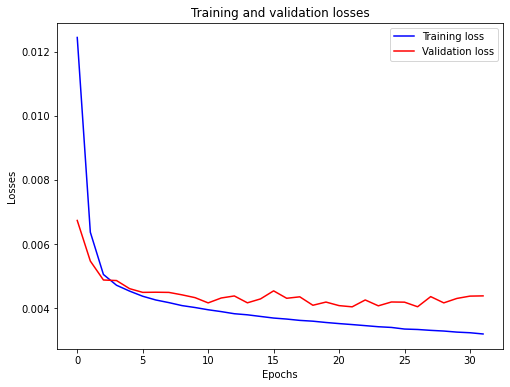

In [131]:
# FULL DATA 
plot_train_history(FULL_LSTMIMO)

In [132]:
FD_predictions = FULL_LSTMIMO.predict(test_longer_inputs['X'])
FD_eval_df = create_evaluation_df(FD_predictions, test_longer_inputs, HORIZON, y_scaler)
#performance['LSTM-MIMO-full-data'] = FULL_LSTMIMO.evaluate(test_inputs['X'],test_inputs['target'], verbose=0)
mape_performance['LSTM-MIMO-full-data'] = mape(FD_eval_df['prediction'], FD_eval_df['actual'])
mse_performance['LSTM-MIMO-full-data'] = validation(FD_eval_df['prediction'], FD_eval_df['actual'], 'RMSE')

In [133]:
MAX_EPOCHS = 50
BATCHSIZE = 10
patience = 10

LSTMIMO = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, input_shape=(24, 5)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(HORIZON)
])

In [134]:
LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [135]:
LSTMIMO.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_31 (Dense)             (None, 24)                792       
Total params: 5,656
Trainable params: 5,656
Non-trainable params: 0
_________________________________________________________________


In [137]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = LSTMIMO.fit(train_inputs['X'], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/50
1368/1368 [==============================] - 22s 16ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2/50
1368/1368 [==============================] - 23s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 3/50
1368/1368 [==============================] - 22s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 4/50
1368/1368 [==============================] - 21s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 5/50
1368/1368 [==============================] - 21s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 6/50
1368/1368 [==============================] - 21s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoc

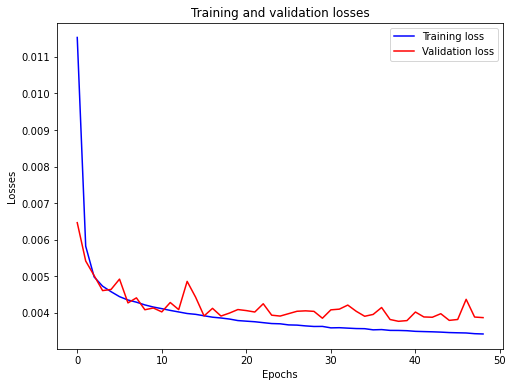

In [138]:
plot_train_history(LSTMIMO)

In [139]:
predictions = LSTMIMO.predict(test_inputs['X'])
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
performance['LSTM-MIMO'] = LSTMIMO.evaluate(test_inputs['X'],test_inputs['target'], verbose=0)
mape_performance['LSTM-MIMO'] = mape(eval_df['prediction'], eval_df['actual'])
mse_performance['LSTM-MIMO'] = validation(eval_df['prediction'], eval_df['actual'], 'RMSE')

[]

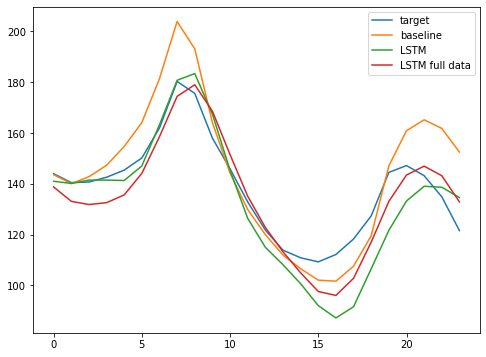

In [140]:
import random
i = random.randint(1,8740)
plt.plot(y_scaler.inverse_transform(test_inputs.dataframe.loc[:,'target'])[i].reshape(24,-1), label='target')
plt.plot(y_scaler.inverse_transform(predictions_B.reshape(-1,24))[i], label='baseline')
plt.plot(y_scaler.inverse_transform(predictions.reshape(-1,24))[i], label='LSTM')
plt.plot(y_scaler.inverse_transform(FD_predictions.reshape(-1,24))[i], label='LSTM full data')
plt.legend()
[]

In [141]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
df = eval_df.groupby('h')['APE'].mean()
df.reindex(['t+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23', 't+24'])

h
t+1     0.026742
t+2     0.039117
t+3     0.052773
t+4     0.066374
t+5     0.077013
t+6     0.085293
t+7     0.089175
t+8     0.093703
t+9     0.098820
t+10    0.103590
t+11    0.107253
t+12    0.111346
t+13    0.114585
t+14    0.116969
t+15    0.119963
t+16    0.123496
t+17    0.126753
t+18    0.129934
t+19    0.130305
t+20    0.130148
t+21    0.130726
t+22    0.133140
t+23    0.134754
t+24    0.131879
Name: APE, dtype: float64

In [145]:
MAX_EPOCHS = 50
BATCHSIZE = 32
patience = 10

ConditionalRNN = Sequential(layers=[ConditionalRNN(32, cell='LSTM'),
                                    Dense(HORIZON)])

In [146]:
ConditionalRNN.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [147]:
ConditionalRNN.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [148]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
tf.keras.backend.set_floatx('float64')
history = ConditionalRNN.fit([train_inputs['X'],train_c1,train_c2], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1367/1368 [============================>.] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'tuple'> input: (<tf.Tensor 'IteratorGetNext:0' shape=(None, 24, 5) dtype=float64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 8) dtype=float64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 2) dtype=float64>)
Consider rewriting this model with the Functional API.
1368/1368 [==============================] - 22s 16ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 2/50
1368/1368 [==============================] - 22s 16ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 3/50
1368/1368 [==============================] - 23s 17ms/step - loss: 0.0054 

Epoch 43/50
1368/1368 [==============================] - 23s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 44/50
1368/1368 [==============================] - 22s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 45/50
1368/1368 [==============================] - 21s 15ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 46/50
1368/1368 [==============================] - 21s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 47/50
1368/1368 [==============================] - 22s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 48/50
1368/1368 [==============================] - 21s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0041 - val_mean_squared_error: 0.004

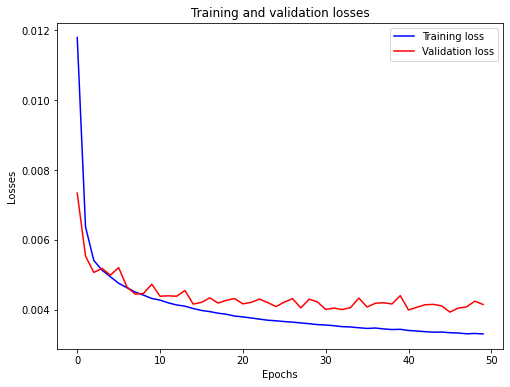

In [149]:
plot_train_history(ConditionalRNN)

In [150]:
performance['ConditionalRNN'] = ConditionalRNN.evaluate([test_inputs['X'],test_c1,test_c2],test_inputs['target'], verbose=0)

In [151]:
cpredictions = ConditionalRNN.predict([test_inputs['X'],test_c1,test_c2])
ceval_df = create_evaluation_df(cpredictions, test_inputs, HORIZON, y_scaler)
mape_performance['ConditionalRNN'] = mape(ceval_df['prediction'], ceval_df['actual'])
mse_performance['ConditionalRNN'] = validation(ceval_df['prediction'], ceval_df['actual'], 'RMSE')

Consider rewriting this model with the Functional API.


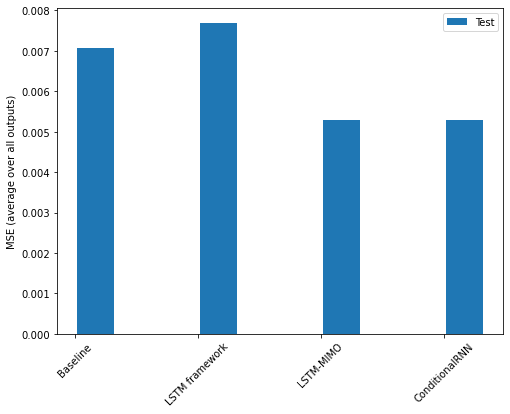

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_squared_error'
metric_index = LSTMIMO.metrics_names.index('mean_squared_error')
#val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

#plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MSE (average over all outputs)')
_ = plt.legend()

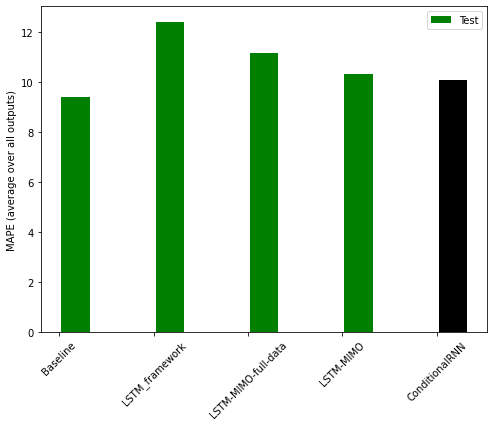

In [152]:
x = np.arange(len(mape_performance))
width = 0.3

metric_name = 'mean_average_percentage_error'
#metric_index = LSTMIMO.metrics_names.index('mean_squared_error')
test_mape = []
for i in mape_performance.values():
    test_mape.append(100*i)

#plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test', color=['green','green','green','green','black'])
plt.xticks(ticks=x, labels=mape_performance.keys(),
           rotation=45)
plt.ylabel('MAPE (average over all outputs)')
_ = plt.legend()

In [157]:
#del mse_performance["Paper"]
mse_performance['Reference'] = 19.5

In [155]:
mse_performance.values()

dict_values([22.475545630579663, 25.361817359190756, 22.189626550775387, 21.093523219531665, 20.688222777371706, 19.0])

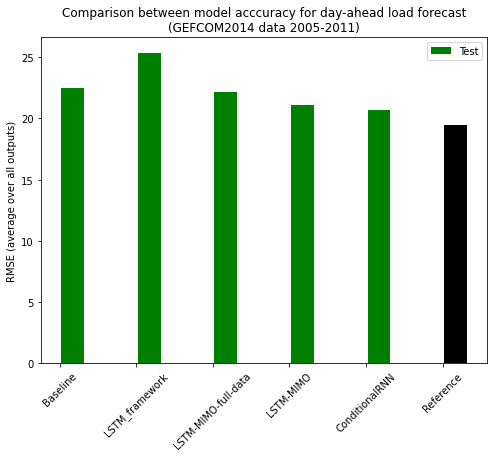

In [158]:
x = np.arange(len(mse_performance))
width = 0.3

metric_name = 'mean_squared_error'
#metric_index = LSTMIMO.metrics_names.index('mean_squared_error')
test_mse = mse_performance.values()

#plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test', color=['green','green','green','green','green', 'black'])
plt.xticks(ticks=x, labels=mse_performance.keys(),
           rotation=45)
plt.ylabel('RMSE (average over all outputs)')
plt.title('Comparison between model acccuracy for day-ahead load forecast\n(GEFCOM2014 data 2005-2011)')
_ = plt.legend()

In [212]:
def validation(forecasted, real, parameter):
    ''' 
    compute some important parameters to compare forecasting results
    '''
    value = 0
    value_1 = 0
    value_2 = 0

    if parameter == 'SMAPE':
        for i in range(len(forecasted)):
            if real[i] + forecasted[i] == 0:
                value += 0
            else: 
                value += ((abs(real[i] - forecasted[i])) / (real[i] + forecasted[i])) * 100
        final_value = value / len(forecasted)  

    elif parameter == 'MAPE':
        for i in range(len(forecasted)):
            if real[i] == 0:
                value += 0
            else: 
                value += (abs(real[i] - forecasted[i]))/real[i]
        final_value = value / len(forecasted) * 100

    elif parameter == 'RMSE':
        for i in range(len(forecasted)):
            value += (real[i] - forecasted[i]) ** 2
        final_value = (value / len(forecasted)) ** (1 / 2) 

    elif parameter == 'R':
        for i in range(len(forecasted)):
            value += (real[i] - np.mean(real)) * (forecasted[i] - np.mean(forecasted))
            value_1 += (real[i] - np.mean(real)) ** 2
            value_2 += (forecasted[i] - np.mean(forecasted)) ** 2

        if value_1 == 0 or value_2 == 0:
            final_value = 100
        else:
            final_value = (value / ((value_1 ** (1 / 2)) * (value_2 ** (1 / 2))))*100

    return final_value